In [14]:
from src.densite_function import *
from src.gaussian_simulation import *
from src.estimators import *
from src.vraisemblance import *
import numpy as np
from numpy.linalg import norm
import matplotlib.pylab as plt
import matplotlib.gridspec as gridspec

# Préalable

On fixe les paramètres optimaux $A$ et $b$ et on tire $\theta \sim \mathcal{N}(0,I_{20})$ selon le cadre expérimental décrit par Rainforth et al. (2018).
On reproduit le modèle génératif décrit par Y. Shi et R. Cornish, i.e $z \sim \mathcal{N}(\theta, I_{20})$ et $x \sim \mathcal{N}(z, I_{20}$)

In [2]:
np.random.seed(123)

theta = simulate_gaussian_vector(mu=np.array([0]*20), sigma=np.identity(20))
z = simulate_gaussian_vector(mu=theta, sigma=np.identity(20))
x = simulate_gaussian_vector(
    mu=z, sigma=np.identity(20))  # on sait simuler x|z

A = np.identity(20)*0.5
b = theta*0.5


# Estimateurs de la log-vraisemblance

## Comparaison entre estimateurs et vraie log-vraisemblance au point x

On prend $k=6$ pour l'estimateur IAWE, $l=0$ pour les autres, de sorte que le coût computationnel espéré de chaque estimateur soit de 6.

In [3]:
np.random.seed(123)
print("Vraie valeur de la log-vraisemblance au point x: {}".format(np.around(log_vraisemblance(x, theta), decimals=2)))
print("Estimateur IAWE de la log-vraisemblance: {}".format(np.around(importance_sampling_logvraisemblance(k=6, theta=theta, A=A, b=b, x=x), decimals=2)))
print("Estimateur SUMO de la log-vraisemblance: {}".format(np.around(estimateur_SUMO_logvraisemblance(theta=theta, A=A, b=b, x=x, r=0.6, l=0), decimals=2)))
print("Estimateur ML-SS de la log-vraisemblance: {}".format(np.around(estimateur_ML_SS_logvraisemblance(x, theta, A, b, r=0.6, l=0), decimals=2)))
print("Estimateur ML-RR de la log-vraisemblance: {}".format(np.around(estimateur_ML_RR_logvraisemblance(x, theta, A, b, r=0.6, l=0), decimals=2)))


Vraie valeur de la log-vraisemblance au point x: -37.99
Estimateur IAWE de la log-vraisemblance: -39.24
Estimateur SUMO de la log-vraisemblance: -38.24
Estimateur ML-SS de la log-vraisemblance: -39.08
Estimateur ML-RR de la log-vraisemblance: -38.23


On prend $k=12$ pour l'estimateur IAWE, $l=4$ pour le SUMO et $l=1$ pour les autres, de sorte que le coût computationnel espéré de chaque estimateur soit environ de 12.

In [4]:
np.random.seed(123)
print("Vraie valeur de la log-vraisemblance au point x: {}".format(np.around(log_vraisemblance(x, theta), decimals=2)))
print("Estimateur IAWE de la log-vraisemblance: {}".format(np.around(importance_sampling_logvraisemblance(k=12, theta=theta, A=A, b=b, x=x), decimals=2)))
print("Estimateur SUMO de la log-vraisemblance: {}".format(np.around(estimateur_SUMO_logvraisemblance(theta=theta, A=A, b=b, x=x, r=0.6, l=4), decimals=2)))
print("Estimateur ML-SS de la log-vraisemblance: {}".format(np.around(estimateur_ML_SS_logvraisemblance(x, theta, A, b, r=0.6, l=1), decimals=2)))
print("Estimateur ML-RR de la log-vraisemblance: {}".format(np.around(estimateur_ML_RR_logvraisemblance(x, theta, A, b, r=0.6, l=1), decimals=2)))

Vraie valeur de la log-vraisemblance au point x: -37.99
Estimateur IAWE de la log-vraisemblance: -38.01
Estimateur SUMO de la log-vraisemblance: -38.12
Estimateur ML-SS de la log-vraisemblance: -41.58
Estimateur ML-RR de la log-vraisemblance: -38.93


## Coût computationnel des estimateurs

On suppose que les estimateurs ML-SS, ML-RR et SUMO contiennent une période de chauffe $l$.
* IWAE: pour produire l'estimateur, on sample $k$ variables aléatoires. Le coût est déterministe: $\mathbb{E}(C_{IWAE})=C_{IWAE}=k$
* ML-SS: pour produire l'estimateur, on sample $2^{K+l+1}$ variables aléatoires, où $K \sim \mathcal{G}(0,6) $. Donc $C_{ML-SS}=2^{K+l+1}$ est aléatoire.
$\mathbb{E}(C_{ML-SS})=6.2^l$
* ML-RR: pour produire l'estimateur, on sample $\sum_{k=0}^{K} 2^{k+l+1}$ variables. Donc $C_{ML-RR}=\sum_{k=0}^K 2^{k+l+1}$. $\mathbb{E}(C_{ML-RR})=6.2^l$
* SUMO: pour produire l'estimateur, on sample $\sum_{k=0}^K(k+l+2)=\frac{K(K+1)}{2}+(l+2)K$ variables. Donc, $C_{SUMO}=\frac{K(K+1)}{2}+(l+2)K$. $\mathbb{E}(C_{SUMO})=\frac{55}{9}+\frac{5}{3}l$

## Procédure de Monte Carlo

On met en place une procédure de Monte Carlo pour estimer le biais et la variance des estimateurs, en fonction du coût computationnel, pour chaque méthode.

L'algorithme est le suivant:

On note $l$: le paramètre de complexité computationnelle propre à chaque estimateur (le nombre de variables samplées pour IWAE, la période de chauffe pour les autres). On note $\mathbf{E}(C(l))$, le coût computationnel espéré pour $l$ fixé. On borne ce coût: $\mathbf{E}(C(l)) \in \{6, 12, 24,..., 384\}$.

Pour $l$ tel que $\mathbf{E}(C(l))=c \in \{6, 12, 24,..., 384\}$:

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Pour m allant de 1 à M, faire:

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Générer $z_m \sim p_{\theta}(z)$

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Générer $x_m \sim p_{\theta}(x|z_m)$

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Calculer chaque estimateur et la log-vraisemblance au point $\mathbb{x_m}$: $estimateur_{m,l}$, $l(x_m, \theta)$

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Fin pour

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Calculer:

\begin{equation}

    biais_{M,l}=\frac{1}{M} \sum_{m=1}^{M}(estimateur_{m,l} - l(x_m;\theta))

\end{equation}

\begin{equation}

    Var_{M,l}=\frac{1}{M} \sum_{m=1}^{M}( estimateur_{m,l} - \frac{1}{M} \sum_{m=1}^{M} estimateur_{m,l})^{2}

\end{equation}


Fin pour

Retourner pour chaque estimateur $(biais_{M,l})_{l}, (Var_{M,l})_{l}$

Les auteurs de l'article prennent $M=1000$. Notons que comme le coût computationnel espéré de l'estimateur SUMO est linéaire (et non géométrique comme le ML-SS et le ML-RR), le paramètre $l$ est choisi à chaque itération tel que $\mathbb{E}(C_{SUMO})$ soit environ égal à la valeur $c$ désirée.

In [5]:
def procedure_MC_logvraisemblance(M, theta, A, b, L):
    """Procédure de Monte Carlo pour estimer le biais et la variance des estimateurs de la log-vraisemblance

    Args:
        M (int): nombre de répétitions de Monte Carlo
        theta (np.array): paramètre d'intérêt
        A (np.array): matrice de dimensions 20*20
        b (np.array): vecteur dans R^20
        L (int): paramètre de complexité maximal

    Returns:
        dict: dictionnaires des biais et des variances. Les clés correspondent aux paramètres de complexité
    """

    biais_IWAE_M = {}
    biais_SUMO_M = {}
    biais_SS_M = {}
    biais_RR_M = {}

    var_IWAE_M = {}
    var_SUMO_M = {}
    var_SS_M = {}
    var_RR_M = {}

    l = 0
    while l <= L:
        m = 1
        estimations_IWAE_M_l = np.array([])
        estimations_SUMO_M_l = np.array([])
        estimations_SS_M_l = np.array([])
        estimations_RR_M_l = np.array([])

        array_biais_IWAE_M_l = np.array([])
        array_biais_SUMO_M_l = np.array([])
        array_biais_SS_M_l = np.array([])
        array_biais_RR_M_l = np.array([])

        while m <= M:
            z = simulate_gaussian_vector(mu=theta, sigma=np.identity(20))
            x = simulate_gaussian_vector(mu=z, sigma=np.identity(20))
            log_vraisemblance_estim_IWAE = importance_sampling_logvraisemblance(
                k=6*2**l, theta=theta, A=A, b=b, x=x)
            log_vraisemblance_estim_SUMO = estimateur_SUMO_logvraisemblance(
                theta=theta, A=A, b=b, x=x, r=0.6, l=l*38)
            log_vraisemblance_estim_SS = estimateur_ML_SS_logvraisemblance(
                theta=theta, A=A, b=b, x=x, r=0.6, l=l)
            log_vraisemblance_estim_RR = estimateur_ML_RR_logvraisemblance(
                theta=theta, A=A, b=b, x=x, r=0.6, l=l)

            array_biais_IWAE_M_l = np.append(
                array_biais_IWAE_M_l, log_vraisemblance_estim_IWAE-log_vraisemblance(x=x, theta=theta))
            array_biais_SUMO_M_l = np.append(
                array_biais_SUMO_M_l, log_vraisemblance_estim_SUMO-log_vraisemblance(x=x, theta=theta))
            array_biais_SS_M_l = np.append(
                array_biais_SS_M_l, log_vraisemblance_estim_SS-log_vraisemblance(x=x, theta=theta))
            array_biais_RR_M_l = np.append(
                array_biais_RR_M_l, log_vraisemblance_estim_RR-log_vraisemblance(x=x, theta=theta))

            estimations_IWAE_M_l = np.append(
                estimations_IWAE_M_l, log_vraisemblance_estim_IWAE)
            estimations_SUMO_M_l = np.append(
                estimations_SUMO_M_l, log_vraisemblance_estim_SUMO)
            estimations_SS_M_l = np.append(
                estimations_SS_M_l, log_vraisemblance_estim_SS)
            estimations_RR_M_l = np.append(
                estimations_RR_M_l, log_vraisemblance_estim_RR)

            m += 1

        biais_IWAE_M_l = np.mean(array_biais_IWAE_M_l)
        biais_SUMO_M_l = np.mean(array_biais_SUMO_M_l)
        biais_SS_M_l = np.mean(array_biais_SS_M_l)
        biais_RR_M_l = np.mean(array_biais_RR_M_l)

        var_IWAE_M_l = np.var(estimations_IWAE_M_l)
        var_SUMO_M_l = np.var(estimations_SUMO_M_l)
        var_SS_M_l = np.var(estimations_SS_M_l)
        var_RR_M_l = np.var(estimations_RR_M_l)

        biais_IWAE_M[l] = biais_IWAE_M_l
        biais_SUMO_M[l] = biais_SUMO_M_l
        biais_SS_M[l] = biais_SS_M_l
        biais_RR_M[l] = biais_RR_M_l

        var_IWAE_M[l] = var_IWAE_M_l
        var_SUMO_M[l] = var_SUMO_M_l
        var_SS_M[l] = var_SS_M_l
        var_RR_M[l] = var_RR_M_l

        l += 1

    return biais_IWAE_M, biais_SUMO_M, biais_SS_M, biais_RR_M, var_IWAE_M, var_SUMO_M, var_SS_M, var_RR_M


In [6]:
np.random.seed(123)

biais_IWAE_M, biais_SUMO_M, biais_SS_M, biais_RR_M, var_IWAE_M, var_SUMO_M, var_SS_M, var_RR_M = procedure_MC_logvraisemblance(M=1000,
                                                                                                                               L=6,
                                                                                                                               theta=theta,
                                                                                                                               A=A,
                                                                                                                               b=b)


In [7]:
print("Biais de l'estimateur IWAE en fonction du coût computationel: {}".format({key : round(biais_IWAE_M[key], 3) for key in biais_IWAE_M}))
print("Biais de l'estimateur SUMO en fonction du coût computationel: {}".format({key : round(biais_SUMO_M[key], 3) for key in biais_SUMO_M}))
print("Biais de l'estimateur ML-SS en fonction du coût computationel: {}".format({key : round(biais_SS_M[key], 3) for key in biais_SS_M}))
print("Biais de l'estimateur ML-RR en fonction du coût computationel: {} \n".format({key : round(biais_RR_M[key], 3) for key in biais_RR_M}))

print("Variance de l'estimateur IWAE en fonction du coût computationel: {}".format({key : round(var_IWAE_M[key], 3) for key in var_IWAE_M}))
print("Variance de l'estimateur SUMO en fonction du coût computationel: {}".format({key : round(var_SUMO_M[key], 3) for key in var_SUMO_M}))
print("Variance de l'estimateur ML-SS en fonction du coût computationel: {}".format({key : round(var_SS_M[key], 3) for key in var_SS_M}))
print("Variance de l'estimateur ML-RR en fonction du coût computationel: {} ".format({key : round(var_RR_M[key], 3) for key in var_RR_M}))


Biais de l'estimateur IWAE en fonction du coût computationel: {0: -0.095, 1: -0.04, 2: -0.013, 3: -0.013, 4: -0.008, 5: 0.001, 6: -0.001}
Biais de l'estimateur SUMO en fonction du coût computationel: {0: -0.177, 1: -0.026, 2: 0.007, 3: -0.021, 4: 0.021, 5: 0.001, 6: -0.001}
Biais de l'estimateur ML-SS en fonction du coût computationel: {0: -1.727, 1: -1.784, 2: -1.906, 3: -1.961, 4: -1.998, 5: -2.015, 6: -2.007}
Biais de l'estimateur ML-RR en fonction du coût computationel: {0: -0.582, 1: -0.782, 2: -0.908, 3: -0.982, 4: -1.021, 5: -1.029, 6: -1.052} 

Variance de l'estimateur IWAE en fonction du coût computationel: {0: 9.304, 1: 9.561, 2: 10.386, 3: 10.22, 4: 9.581, 5: 10.426, 6: 9.555}
Variance de l'estimateur SUMO en fonction du coût computationel: {0: 72.891, 1: 9.525, 2: 10.634, 3: 10.2, 4: 10.239, 5: 10.486, 6: 9.561}
Variance de l'estimateur ML-SS en fonction du coût computationel: {0: 10.092, 1: 9.951, 2: 10.607, 3: 10.752, 4: 9.79, 5: 10.71, 6: 9.891}
Variance de l'estimateur 

C:\Users\yanis\AppData\Local\Temp\ipykernel_62088\3288535316.py:29: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(x_axis, np.square(biais_IAWE), 'b',
C:\Users\yanis\AppData\Local\Temp\ipykernel_62088\3288535316.py:31: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(x_axis, np.square(biais_SUMO), 'b',
C:\Users\yanis\AppData\Local\Temp\ipykernel_62088\3288535316.py:33: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(x_axis, np.square(biais_SS), 'b',
C:\Users\yanis\AppData\Local\Temp\ipykernel_62088\3288535316.py:35: UserWarning: color is redundantly defined by the 'color' keyword argument an

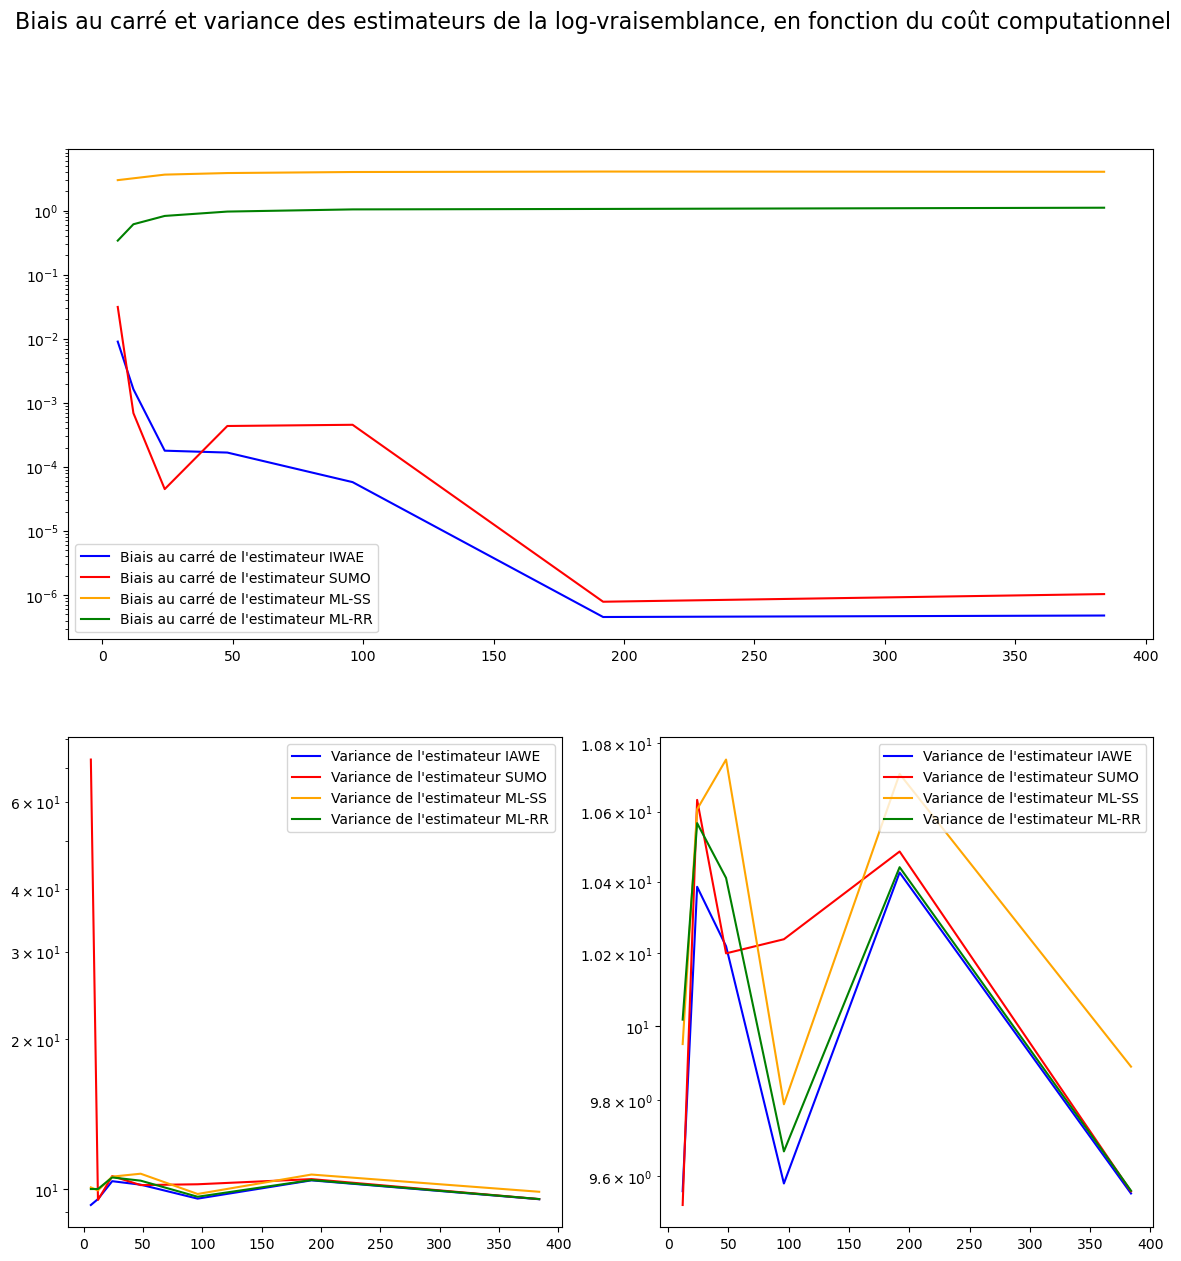

In [32]:
sorted_biais_IWAE_M = sorted(biais_IWAE_M.items())
sorted_biais_SUMO_M = sorted(biais_SUMO_M.items())
sorted_biais_SS_M = sorted(biais_SS_M.items())
sorted_biais_RR_M = sorted(biais_RR_M.items())

sorted_var_IWAE_M = sorted(var_IWAE_M.items())
sorted_var_SUMO_M = sorted(var_SUMO_M.items())
sorted_var_SS_M = sorted(var_SS_M.items())
sorted_var_RR_M = sorted(var_RR_M.items())

l, biais_IAWE = zip(*sorted_biais_IWAE_M)
l, biais_SUMO = zip(*sorted_biais_SUMO_M)
l, biais_SS = zip(*sorted_biais_SS_M)
l, biais_RR = zip(*sorted_biais_RR_M)

l, var_SUMO = zip(*sorted_var_SUMO_M)
l, var_SS = zip(*sorted_var_SS_M)
l, var_RR = zip(*sorted_var_RR_M)
l, var_IAWE = zip(*sorted_var_IWAE_M)

x_axis = [6*2**i for i in l]

gs = gridspec.GridSpec(2, 2)

plt.figure(figsize=(14,14))

axs = plt.subplot(gs[0, :])

plt.plot(x_axis, np.square(biais_IAWE), 'b',
               label="Biais au carré de l'estimateur IWAE", color="blue")
plt.plot(x_axis, np.square(biais_SUMO), 'b',
               label="Biais au carré de l'estimateur SUMO", color="red")
plt.plot(x_axis, np.square(biais_SS), 'b',
               label="Biais au carré de l'estimateur ML-SS", color="orange")
plt.plot(x_axis, np.square(biais_RR), 'b',
               label="Biais au carré de l'estimateur ML-RR", color="green")

plt.yscale("log")
plt.legend()

axs = plt.subplot(gs[1, 0])

plt.plot(x_axis, var_IAWE, 'b',
               label="Variance de l'estimateur IAWE", color="blue")
plt.plot(x_axis, var_SUMO, 'b',
               label="Variance de l'estimateur SUMO", color="red")
plt.plot(x_axis, var_SS, 'b',
               label="Variance de l'estimateur ML-SS", color="orange")
plt.plot(x_axis, var_RR, 'b',
               label="Variance de l'estimateur ML-RR", color="green")

plt.legend()
plt.yscale("log")

axs = plt.subplot(gs[1, 1])

plt.plot(x_axis[1:], var_IAWE[1:], 'b',
               label="Variance de l'estimateur IAWE", color="blue")
plt.plot(x_axis[1:], var_SUMO[1:], 'b',
               label="Variance de l'estimateur SUMO", color="red")
plt.plot(x_axis[1:], var_SS[1:], 'b',
               label="Variance de l'estimateur ML-SS", color="orange")
plt.plot(x_axis[1:], var_RR[1:], 'b',
               label="Variance de l'estimateur ML-RR", color="green")


plt.legend()
plt.yscale("log")

plt.suptitle('Biais au carré et variance des estimateurs de la log-vraisemblance, en fonction du coût computationnel', fontsize=16)
plt.savefig('estimateurs_log_vraisemblance.png')
plt.show()


# Estimateurs du gradient de la log-vraisemblance

## Comparaison entre estimateurs et vrai gradient au point x

On estime le gradient de la log-vraisemblance au point $\mathbf{x}$. On prend $k=6$ pour l'estimateur IAWE, $l=0$ pour les autres, de sorte que le coût computationnel espéré de chaque estimateur soit de 6.

In [35]:
np.random.seed(123)
print("Vraie valeur du gradient de la log-vraisemblance au point x: {}".format(np.around(gradient_log_vraisemblance(x, theta), decimals=2)))
print("Estimateur IAWE du gradient de la log-vraisemblance: {}".format(np.around(importance_sampling_gradientlogvraisemblance(k=6, theta=theta, A=A, b=b, x=x), decimals=2)))
print("Estimateur SUMO du gradient de la log-vraisemblance: {}".format(np.around(estimateur_SUMO_gradientlogvraisemblance(theta=theta, A=A, b=b, x=x, r=0.6, l=0), decimals=2)))
print("Estimateur ML-SS du gradient de la log-vraisemblance: {}".format(np.around(estimateur_ML_SS_gradientlogvraisemblance(x, theta, A, b, r=0.6, l=0), decimals=2)))
print("Estimateur ML-RR du gradient de la log-vraisemblance: {}".format(np.around(estimateur_ML_RR_gradientlogvraisemblance(x, theta, A, b, r=0.6, l=0), decimals=2)))


Vraie valeur du gradient de la log-vraisemblance au point x: [-0.14 -0.47 -2.65  3.5  -1.83 -1.3   6.6  -2.03  1.68  2.75 -3.1  -7.67
 -0.06 -3.    1.91  1.79  1.79  4.89  1.23  2.71]
Estimateur IAWE du gradient de la log-vraisemblance: [ 0.03  0.08 -0.32  0.87 -0.28 -0.31  1.63 -1.13  0.61  0.65 -0.54 -2.85
  0.26 -0.99 -0.09  1.01  0.19  1.18  0.22  0.12]
Estimateur SUMO du gradient de la log-vraisemblance: [-0.02  1.45 -2.37  1.71 -0.31 -0.09  2.82 -1.7   1.46  0.99 -3.05 -3.75
  1.01 -2.98  0.78  0.36  0.84  3.37  0.64  0.76]
Estimateur ML-SS du gradient de la log-vraisemblance: [ 0.38 -0.75 -0.81  1.18 -1.22 -0.86  2.3  -0.84  0.32 -0.65  0.1  -2.97
  0.01 -0.07  0.4   0.01 -0.33  0.6   0.15  0.71]
Estimateur ML-RR du gradient de la log-vraisemblance: [ 0.4   0.28 -0.05 -2.19 -0.4   0.53  0.83 -1.72  2.9   2.06 -1.01 -5.02
  2.87 -1.38 -1.39  1.1   3.42  5.75  2.05  1.33]


On prend $k=12$ pour l'estimateur IAWE, $l=4$ pour le SUMO et $l=1$ pour les autres, de sorte que le coût computationnel espéré de chaque estimateur soit environ de 12.

In [36]:
np.random.seed(123)
print("Vraie valeur du gradient de la log-vraisemblance au point x: {}".format(np.around(gradient_log_vraisemblance(x, theta), decimals=2)))
print("Estimateur IAWE du gradient de la log-vraisemblance: {}".format(np.around(importance_sampling_gradientlogvraisemblance(k=12, theta=theta, A=A, b=b, x=x), decimals=2)))
print("Estimateur SUMO du gradient de la log-vraisemblance: {}".format(np.around(estimateur_SUMO_gradientlogvraisemblance(theta=theta, A=A, b=b, x=x, r=0.6, l=4), decimals=2)))
print("Estimateur ML-SS du gradient de la log-vraisemblance: {}".format(np.around(estimateur_ML_SS_gradientlogvraisemblance(x, theta, A, b, r=0.6, l=1), decimals=2)))
print("Estimateur ML-RR du gradient de la log-vraisemblance: {}".format(np.around(estimateur_ML_RR_gradientlogvraisemblance(x, theta, A, b, r=0.6, l=1), decimals=2)))


Vraie valeur du gradient de la log-vraisemblance au point x: [-0.14 -0.47 -2.65  3.5  -1.83 -1.3   6.6  -2.03  1.68  2.75 -3.1  -7.67
 -0.06 -3.    1.91  1.79  1.79  4.89  1.23  2.71]
Estimateur IAWE du gradient de la log-vraisemblance: [-0.2  -0.27 -0.18  1.18  0.05 -0.83  2.01 -0.92  0.33  0.63 -1.18 -2.01
 -0.43 -1.08  0.43  0.97  0.69  1.23  0.49  0.55]
Estimateur SUMO du gradient de la log-vraisemblance: [ 0.09 -0.39 -0.75  0.99 -1.13 -0.15  1.78 -0.28  0.29  0.57 -0.76 -2.11
  0.1  -1.56  0.56  0.45  0.42  1.41  0.42  0.59]
Estimateur ML-SS du gradient de la log-vraisemblance: [-0.29 -0.53 -0.91  1.12 -0.19 -0.39  1.27 -0.95  0.36  0.19 -0.08 -0.45
 -0.08 -0.76 -1.15  1.24 -0.46  0.61  0.66 -1.04]
Estimateur ML-RR du gradient de la log-vraisemblance: [ 1.21  0.59  0.38  0.36  0.05 -0.15  2.23 -0.04  0.74  1.27  0.26 -2.5
 -1.2  -0.5  -0.27  0.28  0.22  1.15  2.85  0.96]


## Procédure de Monte Carlo

On réplique la procédure précédente. Le gradient de la log-vraisemblance ainsi que les différents estimateurs associés sont dans $\mathbb{R}^{20}$. Ainsi, on adapte la définition du biais au carré et de la variance, de sorte à avoir une valeur réelle.

\begin{equation}

    biais_{M,l}=\frac{1}{M} \sum_{m=1}^{M}(estimateur_{m,l} - \nabla_{\theta}l(x_m;\theta))

\end{equation}

\begin{equation}

    biais^2_{M,l}=\lVert biais_{M,l} \rVert^2

\end{equation}

\begin{equation}

    Var_{M,l}=\frac{1}{M} \sum_{m=1}^{M} \lVert estimateur_{m,l} - \frac{1}{M} \sum_{m=1}^{M} estimateur_{m,l} \rVert^{2}

\end{equation}

In [37]:
def procedure_MC_gradientlogvraisemblance(M, theta, A, b, L):
    """Procédure de Monte Carlo pour estimer le biais et la variance des estimateurs du gradient de la log-vraisemblance

    Args:
        M (int): nombre de répétitions de Monte Carlo
        theta (np.array): paramètre d'intérêt
        A (np.array): matrice de dimensions 20*20
        b (np.array): vecteur dans R^20
        L (int): paramètre de complexité maximal

    Returns:
        dict: dictionnaires des biais et des variances. Les clés correspondent aux paramètres de complexité
    """

    biais_IWAE_M = {}
    biais_SUMO_M = {}
    biais_SS_M = {}
    biais_RR_M = {}

    var_IWAE_M = {}
    var_SUMO_M = {}
    var_SS_M = {}
    var_RR_M = {}

    l = 0
    while l <= L:
        m = 1
        estimations_IWAE_M_l = np.array([])
        estimations_SUMO_M_l = np.array([])
        estimations_SS_M_l = np.array([])
        estimations_RR_M_l = np.array([])

        array_biais_IWAE_M_l = np.array([])
        array_biais_SUMO_M_l = np.array([])
        array_biais_SS_M_l = np.array([])
        array_biais_RR_M_l = np.array([])

        while m <= M:
            z = simulate_gaussian_vector(mu=theta, sigma=np.identity(20))
            x = simulate_gaussian_vector(mu=z, sigma=np.identity(20))
            gradient_log_vraisemblance_estim_IWAE = importance_sampling_gradientlogvraisemblance(k=6*2**l, theta=theta, A=A, b=b, x=x)
            gradient_log_vraisemblance_estim_SUMO = estimateur_SUMO_gradientlogvraisemblance(theta=theta, A=A, b=b, x=x, r=0.6, l=l*38)
            gradient_log_vraisemblance_estim_SS = estimateur_ML_SS_gradientlogvraisemblance(theta=theta, A=A, b=b, x=x, r=0.6, l=l)
            gradient_log_vraisemblance_estim_RR = estimateur_ML_RR_gradientlogvraisemblance(theta=theta, A=A, b=b, x=x, r=0.6, l=l)

            if m == 1:
                estimations_IWAE_M_l = np.append(estimations_IWAE_M_l, gradient_log_vraisemblance_estim_IWAE)
                estimations_SUMO_M_l = np.append(estimations_SUMO_M_l, gradient_log_vraisemblance_estim_SUMO)
                estimations_SS_M_l = np.append(estimations_SS_M_l, gradient_log_vraisemblance_estim_SS)
                estimations_RR_M_l = np.append(estimations_RR_M_l, gradient_log_vraisemblance_estim_RR)

                array_biais_IWAE_M_l = np.append(array_biais_IWAE_M_l, gradient_log_vraisemblance_estim_IWAE-gradient_log_vraisemblance(x, theta))
                array_biais_SUMO_M_l = np.append(array_biais_SUMO_M_l, gradient_log_vraisemblance_estim_SUMO-gradient_log_vraisemblance(x, theta))
                array_biais_SS_M_l = np.append(array_biais_SS_M_l, gradient_log_vraisemblance_estim_SS-gradient_log_vraisemblance(x, theta))
                array_biais_RR_M_l = np.append(array_biais_RR_M_l, gradient_log_vraisemblance_estim_RR-gradient_log_vraisemblance(x, theta))

            else:
                estimations_IWAE_M_l = np.vstack((estimations_IWAE_M_l, gradient_log_vraisemblance_estim_IWAE))
                estimations_SUMO_M_l = np.vstack((estimations_SUMO_M_l, gradient_log_vraisemblance_estim_SUMO))
                estimations_SS_M_l = np.vstack((estimations_SS_M_l, gradient_log_vraisemblance_estim_SS))
                estimations_RR_M_l = np.vstack((estimations_RR_M_l, gradient_log_vraisemblance_estim_RR))

                array_biais_IWAE_M_l = np.vstack((array_biais_IWAE_M_l, gradient_log_vraisemblance_estim_IWAE-gradient_log_vraisemblance(x, theta)))
                array_biais_SUMO_M_l = np.vstack((array_biais_SUMO_M_l, gradient_log_vraisemblance_estim_SUMO-gradient_log_vraisemblance(x, theta)))
                array_biais_SS_M_l = np.vstack((array_biais_SS_M_l, gradient_log_vraisemblance_estim_SS-gradient_log_vraisemblance(x, theta)))
                array_biais_RR_M_l = np.vstack((array_biais_RR_M_l, gradient_log_vraisemblance_estim_RR-gradient_log_vraisemblance(x, theta)))
            m += 1

        biais_IWAE_M_l = np.mean(array_biais_IWAE_M_l, axis=0)
        biais_SUMO_M_l = np.mean(array_biais_SUMO_M_l, axis=0)
        biais_SS_M_l = np.mean(array_biais_SS_M_l, axis=0)
        biais_RR_M_l = np.mean(array_biais_RR_M_l, axis=0)

        norm_biais_IWAE_M_l = norm(biais_IWAE_M_l)
        norm_biais_SUMO_M_l = norm(biais_SUMO_M_l)
        norm_biais_SS_M_l = norm(biais_SS_M_l)
        norm_biais_RR_M_l = norm(biais_RR_M_l)

        var_IWAE_M_l = np.mean(norm(estimations_IWAE_M_l-np.mean(estimations_IWAE_M_l, axis=0), axis=1)**2)
        var_SUMO_M_l = np.mean(norm(estimations_SUMO_M_l-np.mean(estimations_SUMO_M_l, axis=0), axis=1)**2)
        var_SS_M_l = np.mean(norm(estimations_SS_M_l-np.mean(estimations_SS_M_l, axis=0), axis=1)**2)
        var_RR_M_l = np.mean(norm(estimations_RR_M_l-np.mean(estimations_RR_M_l, axis=0), axis=1)**2)

        biais_IWAE_M[l] = norm_biais_IWAE_M_l
        biais_SUMO_M[l] = norm_biais_SUMO_M_l
        biais_SS_M[l] = norm_biais_SS_M_l
        biais_RR_M[l] = norm_biais_RR_M_l

        var_IWAE_M[l] = var_IWAE_M_l
        var_SUMO_M[l] = var_SUMO_M_l
        var_SS_M[l] = var_SS_M_l
        var_RR_M[l] = var_RR_M_l

        l += 1

    return biais_IWAE_M, biais_SUMO_M, biais_SS_M, biais_RR_M, var_IWAE_M, var_SUMO_M, var_SS_M, var_RR_M


In [38]:
np.random.seed(123)

biais_IWAE_M_gradient, biais_SUMO_M_gradient, biais_SS_M_gradient, biais_RR_M_gradient, var_IWAE_M_gradient, var_SUMO_M_gradient, var_SS_M_gradient, var_RR_M_gradient = procedure_MC_gradientlogvraisemblance(M=1000,
                                                                                                                                                                                                               L=6,
                                                                                                                                                                                                               theta=theta,
                                                                                                                                                                                                               A=A,
                                                                                                                                                                                                               b=b)


In [41]:
print("Biais de l'estimateur IWAE en fonction du coût computationel: {}".format({key : round(biais_IWAE_M_gradient[key], 3) for key in biais_IWAE_M_gradient}))
print("Biais de l'estimateur SUMO en fonction du coût computationel: {}".format({key : round(biais_SUMO_M_gradient[key], 3) for key in biais_SUMO_M_gradient}))
print("Biais de l'estimateur ML-SS en fonction du coût computationel: {}".format({key : round(biais_SS_M_gradient[key], 3) for key in biais_SS_M_gradient}))
print("Biais de l'estimateur ML-RR en fonction du coût computationel: {} \n".format({key : round(biais_RR_M_gradient[key], 3) for key in biais_RR_M_gradient}))

print("Variance de l'estimateur IWAE en fonction du coût computationel: {}".format({key : round(var_IWAE_M_gradient[key], 3) for key in var_IWAE_M_gradient}))
print("Variance de l'estimateur SUMO en fonction du coût computationel: {}".format({key : round(var_SUMO_M_gradient[key], 3) for key in var_SUMO_M_gradient}))
print("Variance de l'estimateur ML-SS en fonction du coût computationel: {}".format({key : round(var_SS_M_gradient[key], 3) for key in var_SS_M_gradient}))
print("Variance de l'estimateur ML-RR en fonction du coût computationel: {} ".format({key : round(var_RR_M_gradient[key], 3) for key in var_RR_M_gradient}))

Biais de l'estimateur IWAE en fonction du coût computationel: {0: 0.223, 1: 0.29, 2: 0.325, 3: 0.345, 4: 0.301, 5: 0.321, 6: 0.282}
Biais de l'estimateur SUMO en fonction du coût computationel: {0: 0.229, 1: 0.292, 2: 0.324, 3: 0.342, 4: 0.308, 5: 0.322, 6: 0.284}
Biais de l'estimateur ML-SS en fonction du coût computationel: {0: 6.523, 1: 4.799, 2: 7.543, 3: 6.396, 4: 3.751, 5: 8.939, 6: 5.006}
Biais de l'estimateur ML-RR en fonction du coût computationel: {0: 9.079, 1: 4.356, 2: 7.751, 3: 5.963, 4: 5.877, 5: 4.85, 6: 5.853} 

Variance de l'estimateur IWAE en fonction du coût computationel: {0: 12.597, 1: 11.48, 2: 10.643, 3: 10.216, 4: 10.121, 5: 9.96, 6: 10.094}
Variance de l'estimateur SUMO en fonction du coût computationel: {0: 33.591, 1: 10.553, 2: 10.119, 3: 10.008, 4: 10.086, 5: 9.965, 6: 10.112}
Variance de l'estimateur ML-SS en fonction du coût computationel: {0: 3059.195, 1: 3523.25, 2: 5063.893, 3: 3891.625, 4: 768.377, 5: 20697.829, 6: 825.867}
Variance de l'estimateur ML-

C:\Users\yanis\AppData\Local\Temp\ipykernel_62088\1961737260.py:24: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  axs[0].plot(x_axis, np.square(biais_IAWE_gradient), 'b',
C:\Users\yanis\AppData\Local\Temp\ipykernel_62088\1961737260.py:26: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  axs[0].plot(x_axis, np.square(biais_SUMO_gradient), 'b',
C:\Users\yanis\AppData\Local\Temp\ipykernel_62088\1961737260.py:28: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  axs[0].plot(x_axis, np.square(biais_SS_gradient), 'b',
C:\Users\yanis\AppData\Local\Temp\ipykernel_62088\1961737260.py:30: UserWarning: color is redundantly define

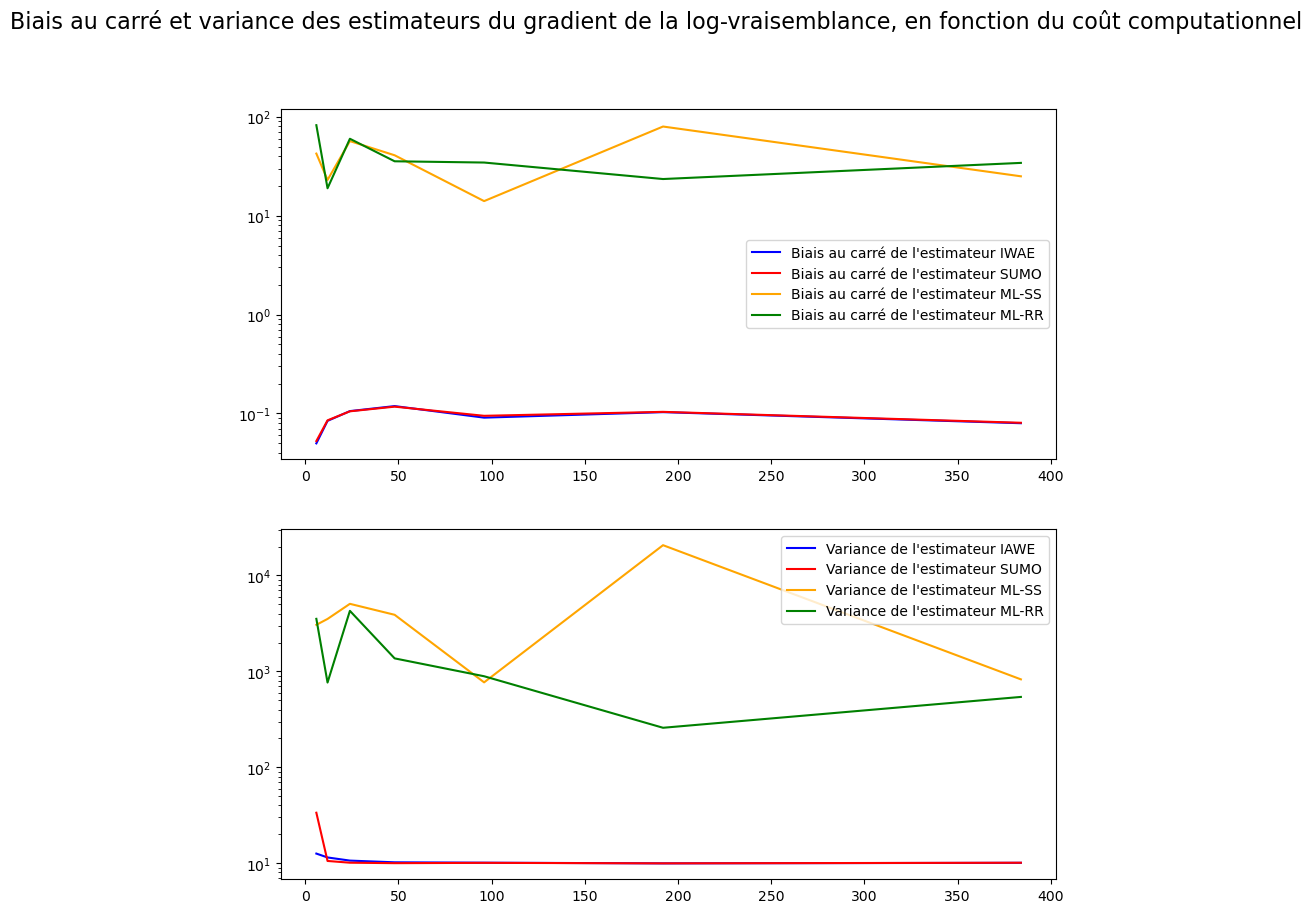

In [44]:
sorted_biais_IWAE_M_gradient = sorted(biais_IWAE_M_gradient.items())
sorted_biais_SUMO_M_gradient = sorted(biais_SUMO_M_gradient.items())
sorted_biais_SS_M_gradient = sorted(biais_SS_M_gradient.items())
sorted_biais_RR_M_gradient = sorted(biais_RR_M_gradient.items())

sorted_var_IWAE_M_gradient = sorted(var_IWAE_M_gradient.items())
sorted_var_SUMO_M_gradient = sorted(var_SUMO_M_gradient.items())
sorted_var_SS_M_gradient = sorted(var_SS_M_gradient.items())
sorted_var_RR_M_gradient = sorted(var_RR_M_gradient.items())

l, biais_IAWE_gradient = zip(*sorted_biais_IWAE_M_gradient)
l, biais_SUMO_gradient = zip(*sorted_biais_SUMO_M_gradient)
l, biais_SS_gradient = zip(*sorted_biais_SS_M_gradient)
l, biais_RR_gradient = zip(*sorted_biais_RR_M_gradient)

l, var_IAWE_gradient = zip(*sorted_var_IWAE_M_gradient)
l, var_SUMO_gradient = zip(*sorted_var_SUMO_M_gradient)
l, var_SS_gradient = zip(*sorted_var_SS_M_gradient)
l, var_RR_gradient = zip(*sorted_var_RR_M_gradient)

fig, axs = plt.subplots(2, 1, figsize=(10, 10))


axs[0].plot(x_axis, np.square(biais_IAWE_gradient), 'b',
               label="Biais au carré de l'estimateur IWAE", color="blue")
axs[0].plot(x_axis, np.square(biais_SUMO_gradient), 'b',
               label="Biais au carré de l'estimateur SUMO", color="red")
axs[0].plot(x_axis, np.square(biais_SS_gradient), 'b',
               label="Biais au carré de l'estimateur ML-SS", color="orange")
axs[0].plot(x_axis, np.square(biais_RR_gradient), 'b',
               label="Biais au carré de l'estimateur ML-RR", color="green")

axs[0].set_yscale("log")

axs[0].legend()

fig.suptitle('Biais au carré et variance des estimateurs du gradient de la log-vraisemblance, en fonction du coût computationnel', fontsize=16)

axs[1].plot(x_axis, var_IAWE_gradient, 'b',
               label="Variance de l'estimateur IAWE", color="blue")
axs[1].plot(x_axis, var_SUMO_gradient, 'b',
               label="Variance de l'estimateur SUMO", color="red")
axs[1].plot(x_axis, var_SS_gradient, 'b',
               label="Variance de l'estimateur ML-SS", color="orange")
axs[1].plot(x_axis, var_RR_gradient, 'b',
               label="Variance de l'estimateur ML-RR", color="green")

axs[1].set_yscale("log")

axs[1].legend()

plt.savefig('estimateurs_gradient_log_vraisemblance.png')
plt.show()


In [ ]:
# %store biais_IWAE_M
# %store biais_SUMO_M
# %store biais_SS_M
# %store biais_RR_M
# %store var_IWAE_M
# %store var_SUMO_M
# %store var_SS_M
# %store var_RR_M

# %store biais_IWAE_M_gradient
# %store biais_SUMO_M_gradient
# %store biais_SS_M_gradient
# %store biais_RR_M_gradient
# %store var_IWAE_M_gradient
# %store var_SUMO_M_gradient
# %store var_SS_M_gradient
# %store var_RR_M_gradient


# Graphe des moyennes ergodiques

## Estimateurs de la log-vraisemblance

Au vu des résultats obtenus, nous nous demandons si le choix de $M$ est suffisant pour assurer une convergence du biais et de la variance vers leurs valeurs théoriques respectives. Pour voir si le choix de $M$ est suffisant, on trace le graphique des moyennes ergodiques à coût computationnel fixé. On voit un pic important en termes de biais est atteint pour un coût de $6.2^5=192$. L'algorithme est donc le suivant:

Fixer le coût computationnel espéré à 192

Pour M=250, 500, 750, 1000, 1250, 1500, 1750, 2000:

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Pour m=1,...,M:

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Générer $z_m \sim p_{\theta}(z)$

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Générer $x_m \sim p_{\theta}(x|z_m)$

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Calculer chaque estimateur et la log-vraisemblance au point $\mathbb{x}$: $estimateur_{m,M}$, $l(x_m, \theta)$

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Fin pour

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Pour chaque estimateur, calculer $Biais_M$, $Var_M$

Fin pour

Retourner $(Biais_M)_{M=250,...,2000}$, $(Var_M)_{M=250,...,2000}$


In [47]:
def moyennes_ergodiques_log_vraisemblance(theta, A, b):

    biais_IWAE_M = {}
    biais_SUMO_M = {}
    biais_SS_M = {}
    biais_RR_M = {}

    var_IWAE_M = {}
    var_SUMO_M = {}
    var_SS_M = {}
    var_RR_M = {}

    for M in range(250, 2250, 250):

        estimations_IWAE_m = np.array([])
        estimations_SUMO_m = np.array([])
        estimations_SS_m = np.array([])
        estimations_RR_m = np.array([])

        array_biais_IWAE_m = np.array([])
        array_biais_SUMO_m = np.array([])
        array_biais_SS_m = np.array([])
        array_biais_RR_m = np.array([])

        for m in range(1,M+1):
            z = simulate_gaussian_vector(mu=theta, sigma=np.identity(20))
            x = simulate_gaussian_vector(mu=z, sigma=np.identity(20))

            log_vraisemblance_estim_IWAE = importance_sampling_logvraisemblance(k=6*2**5, theta=theta, A=A, b=b, x=x)
            log_vraisemblance_estim_SUMO = estimateur_SUMO_logvraisemblance(theta=theta, A=A, b=b, x=x, r=0.6, l=5*38)
            log_vraisemblance_estim_SS = estimateur_ML_SS_logvraisemblance(theta=theta, A=A, b=b, x=x, r=0.6, l=5)
            log_vraisemblance_estim_RR = estimateur_ML_RR_logvraisemblance(theta=theta, A=A, b=b, x=x, r=0.6, l=5)

            estimations_IWAE_m = np.append(estimations_IWAE_m, log_vraisemblance_estim_IWAE)
            estimations_SUMO_m = np.append(estimations_SUMO_m, log_vraisemblance_estim_SUMO)
            estimations_SS_m = np.append(estimations_SS_m, log_vraisemblance_estim_SS)
            estimations_RR_m = np.append(estimations_RR_m, log_vraisemblance_estim_RR)

            array_biais_IWAE_m=np.append(array_biais_IWAE_m, log_vraisemblance_estim_IWAE- log_vraisemblance(x=x, theta=theta))
            array_biais_SUMO_m=np.append(array_biais_SUMO_m, log_vraisemblance_estim_SUMO- log_vraisemblance(x=x, theta=theta))
            array_biais_SS_m=np.append(array_biais_SS_m,log_vraisemblance_estim_SS- log_vraisemblance(x=x, theta=theta))
            array_biais_RR_m=np.append(array_biais_RR_m, log_vraisemblance_estim_RR- log_vraisemblance(x=x, theta=theta))

        biais_IWAE_m = np.mean(array_biais_IWAE_m)
        biais_SUMO_m = np.mean(array_biais_SUMO_m)
        biais_SS_m = np.mean(array_biais_SS_m)
        biais_RR_m = np.mean(array_biais_RR_m)

        var_IWAE_m = np.var(estimations_IWAE_m)
        var_SUMO_m = np.var(estimations_SUMO_m)
        var_SS_m = np.var(estimations_SS_m)
        var_RR_m = np.var(estimations_RR_m)

        biais_IWAE_M[m] = biais_IWAE_m
        biais_SUMO_M[m] = biais_SUMO_m
        biais_SS_M[m] = biais_SS_m
        biais_RR_M[m] = biais_RR_m

        var_IWAE_M[m] = var_IWAE_m
        var_SUMO_M[m] = var_SUMO_m
        var_SS_M[m] = var_SS_m
        var_RR_M[m] = var_RR_m

    return biais_IWAE_M, biais_SUMO_M, biais_SS_M, biais_RR_M, var_IWAE_M, var_SUMO_M, var_SS_M, var_RR_M


In [48]:
np.random.seed(123)

biais_IWAE_ergo, biais_SUMO_ergo, biais_SS_ergo, biais_RR_ergo, var_IWAE_ergo, var_SUMO_ergo, var_SS_ergo, var_RR_ergo = moyennes_ergodiques_log_vraisemblance(theta=theta,
                                                                                                                                                               A=A,
                                                                                                                                                               b=b)


In [49]:
print("Biais de l'estimateur IWAE pour un coût de 192 en fonction de M: {}".format({key : round(biais_IWAE_ergo[key], 3) for key in biais_IWAE_ergo}))
print("Biais de l'estimateur SUMO pour un coût de 192 en fonction de M: {}".format({key : round(biais_SUMO_ergo[key], 3) for key in biais_SUMO_ergo}))
print("Biais de l'estimateur ML-SS pour un coût de 192 en fonction de M: {}".format({key : round(biais_SS_ergo[key], 3) for key in biais_SS_ergo}))
print("Biais de l'estimateur ML-RR pour un coût de 192 en fonction de M: {} \n".format({key : round(biais_RR_ergo[key], 3) for key in biais_RR_ergo}))

print("Variance de l'estimateur IWAE pour un coût de 192 en fonction de M: {}".format({key : round(var_IWAE_ergo[key], 3) for key in var_IWAE_ergo}))
print("Variance de l'estimateur SUMO pour un coût de 192 en fonction de M: {}".format({key : round(var_SUMO_ergo[key], 3) for key in var_SUMO_ergo}))
print("Variance de l'estimateur ML-SS pour un coût de 192 en fonction de M: {}".format({key : round(var_SS_ergo[key], 3) for key in var_SS_ergo}))
print("Variance de l'estimateur ML-RR pour un coût de 192 en fonction de M: {} ".format({key : round(var_RR_ergo[key], 3) for key in var_RR_ergo}))

Biais de l'estimateur IWAE pour un coût de 192 en fonction de M: {250: 0.002, 500: 0.003, 750: -0.004, 1000: -0.004, 1250: 0.002, 1500: -0.004, 1750: -0.001, 2000: -0.001}
Biais de l'estimateur SUMO pour un coût de 192 en fonction de M: {250: -0.004, 500: -0.004, 750: -0.005, 1000: -0.007, 1250: -0.005, 1500: -0.014, 1750: -0.007, 2000: -0.017}
Biais de l'estimateur ML-SS pour un coût de 192 en fonction de M: {250: -1.964, 500: -2.044, 750: -2.042, 1000: -2.022, 1250: -2.001, 1500: -2.02, 1750: -2.028, 2000: -2.024}
Biais de l'estimateur ML-RR pour un coût de 192 en fonction de M: {250: -1.061, 500: -1.04, 750: -1.033, 1000: -1.033, 1250: -1.041, 1500: -1.035, 1750: -1.044, 2000: -1.042} 

Variance de l'estimateur IWAE pour un coût de 192 en fonction de M: {250: 12.079, 500: 11.165, 750: 10.901, 1000: 10.485, 1250: 9.992, 1500: 10.419, 1750: 9.485, 2000: 10.124}
Variance de l'estimateur SUMO pour un coût de 192 en fonction de M: {250: 12.101, 500: 11.164, 750: 10.897, 1000: 10.483, 125

C:\Users\yanis\AppData\Local\Temp\ipykernel_62088\3164497666.py:24: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  axs[0].plot(M, np.square(biais_IAWE), 'b',
C:\Users\yanis\AppData\Local\Temp\ipykernel_62088\3164497666.py:26: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  axs[0].plot(M, np.square(biais_SUMO), 'b',
C:\Users\yanis\AppData\Local\Temp\ipykernel_62088\3164497666.py:28: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  axs[0].plot(M, np.square(biais_SS), 'b',
C:\Users\yanis\AppData\Local\Temp\ipykernel_62088\3164497666.py:30: UserWarning: color is redundantly defined by the 'color' keyword argument and the 

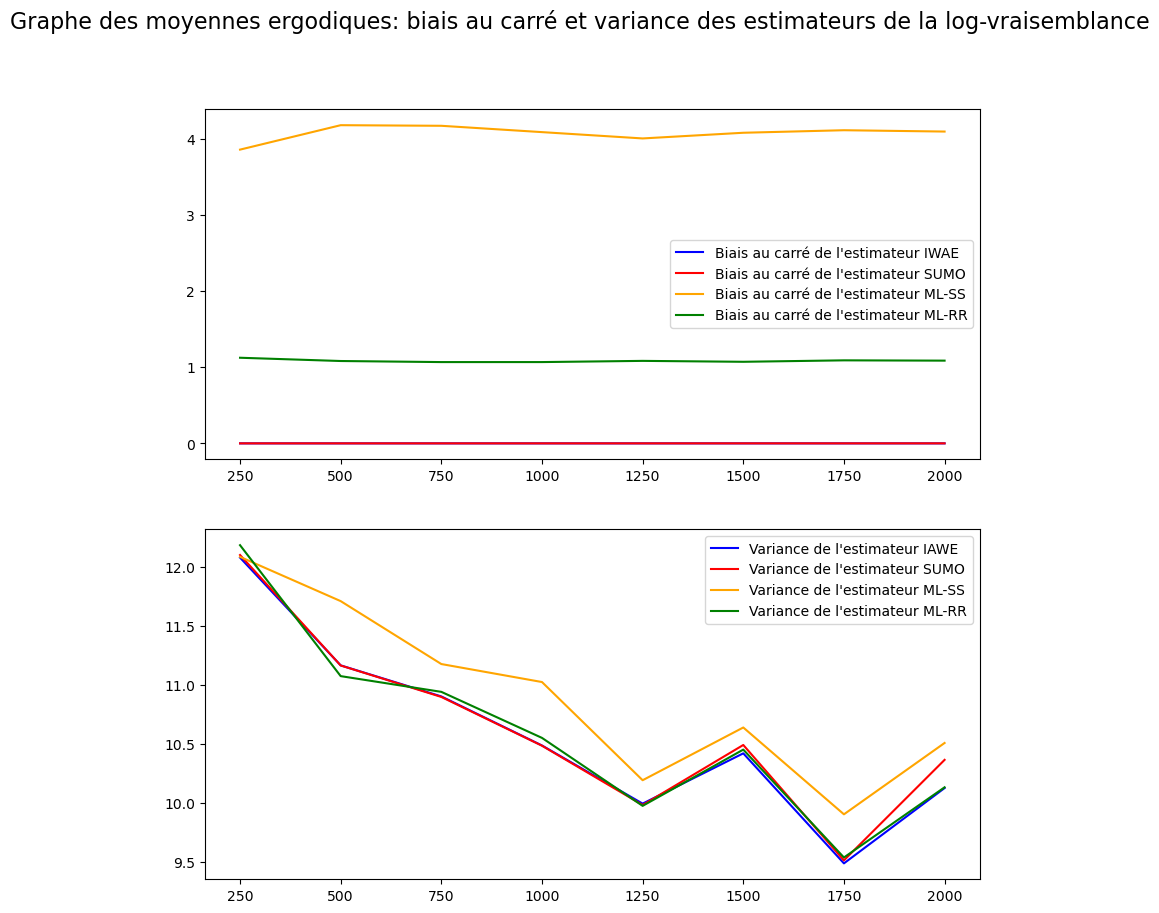

In [62]:
sorted_biais_IWAE_M = sorted(biais_IWAE_ergo.items())
sorted_biais_SUMO_M = sorted(biais_SUMO_ergo.items())
sorted_biais_SS_M = sorted(biais_SS_ergo.items())
sorted_biais_RR_M = sorted(biais_RR_ergo.items())

sorted_var_IWAE_M = sorted(var_IWAE_ergo.items())
sorted_var_SUMO_M = sorted(var_SUMO_ergo.items())
sorted_var_SS_M = sorted(var_SS_ergo.items())
sorted_var_RR_M = sorted(var_RR_ergo.items())

M, biais_IAWE = zip(*sorted_biais_IWAE_M)
M, biais_SUMO = zip(*sorted_biais_SUMO_M)
M, biais_SS = zip(*sorted_biais_SS_M)
M, biais_RR = zip(*sorted_biais_RR_M)

M, var_SUMO = zip(*sorted_var_SUMO_M)
M, var_SS = zip(*sorted_var_SS_M)
M, var_RR = zip(*sorted_var_RR_M)
M, var_IAWE = zip(*sorted_var_IWAE_M)


fig, axs = plt.subplots(2, 1, figsize=(10, 10))

axs[0].plot(M, np.square(biais_IAWE), 'b',
            label="Biais au carré de l'estimateur IWAE", color="blue")
axs[0].plot(M, np.square(biais_SUMO), 'b',
            label="Biais au carré de l'estimateur SUMO", color="red")
axs[0].plot(M, np.square(biais_SS), 'b',
            label="Biais au carré de l'estimateur ML-SS", color="orange")
axs[0].plot(M, np.square(biais_RR), 'b',
            label="Biais au carré de l'estimateur ML-RR", color="green")

axs[0].legend()

axs[1].plot(M, var_IAWE, 'b',
            label="Variance de l'estimateur IAWE", color="blue")
axs[1].plot(M, var_SUMO, 'b',
            label="Variance de l'estimateur SUMO", color="red")
axs[1].plot(M, var_SS, 'b',
            label="Variance de l'estimateur ML-SS", color="orange")
axs[1].plot(M, var_RR, 'b',
            label="Variance de l'estimateur ML-RR", color="green")


axs[1].legend()

fig.suptitle('Graphe des moyennes ergodiques: biais au carré et variance des estimateurs de la log-vraisemblance', fontsize=16)
plt.savefig('moyenne_ergo_logvrais.png')
plt.show()


## Estimateurs du gradient de la log-vraisemblance

Concernant, les estimateurs du gradient de la log-vraisemblance, on a un pic du biais et de variance pour les estimateurs ML-SS et ML-RR lorsque le coût computationnel espéré est aussi égal à 192. On refait donc la procédure en fixant ce coût.

In [55]:
def moyennes_ergodiques_gradient_log_vraisemblance(theta, A, b):

    biais_IWAE_M = {}
    biais_SUMO_M = {}
    biais_SS_M = {}
    biais_RR_M = {}

    var_IWAE_M = {}
    var_SUMO_M = {}
    var_SS_M = {}
    var_RR_M = {}

    for M in range(250, 2250, 250):
        estimations_IWAE_m = np.array([])
        estimations_SUMO_m = np.array([])
        estimations_SS_m = np.array([])
        estimations_RR_m = np.array([])

        array_biais_IWAE_m=np.array([])
        array_biais_SUMO_m=np.array([])
        array_biais_SS_m=np.array([])
        array_biais_RR_m=np.array([])


        for m in range(1,M+1):
            z = simulate_gaussian_vector(mu=theta, sigma=np.identity(20))
            x = simulate_gaussian_vector(mu=z, sigma=np.identity(20))
            gradient_log_vraisemblance_estim_IWAE = importance_sampling_gradientlogvraisemblance(k=6*2**5, theta=theta, A=A, b=b, x=x)
            gradient_log_vraisemblance_estim_SUMO = estimateur_SUMO_gradientlogvraisemblance(theta=theta, A=A, b=b, x=x, r=0.6, l=5*38)
            gradient_log_vraisemblance_estim_SS = estimateur_ML_SS_gradientlogvraisemblance(theta=theta, A=A, b=b, x=x, r=0.6, l=5)
            gradient_log_vraisemblance_estim_RR = estimateur_ML_RR_gradientlogvraisemblance(theta=theta, A=A, b=b, x=x, r=0.6, l=5)

            if m == 1:
                estimations_IWAE_m = np.append(estimations_IWAE_m, gradient_log_vraisemblance_estim_IWAE)
                estimations_SUMO_m = np.append(estimations_SUMO_m, gradient_log_vraisemblance_estim_SUMO)
                estimations_SS_m = np.append(estimations_SS_m, gradient_log_vraisemblance_estim_SS)
                estimations_RR_m = np.append(estimations_RR_m, gradient_log_vraisemblance_estim_RR)

                array_biais_IWAE_m = np.append(array_biais_IWAE_m, gradient_log_vraisemblance_estim_IWAE- gradient_log_vraisemblance(x=x, theta=theta))
                array_biais_SUMO_m = np.append(array_biais_SUMO_m, gradient_log_vraisemblance_estim_SUMO- gradient_log_vraisemblance(x=x, theta=theta))
                array_biais_SS_m = np.append(array_biais_SS_m, gradient_log_vraisemblance_estim_SS- gradient_log_vraisemblance(x=x, theta=theta))
                array_biais_RR_m = np.append(array_biais_RR_m, gradient_log_vraisemblance_estim_RR- gradient_log_vraisemblance(x=x, theta=theta))

            else:
                estimations_IWAE_m = np.vstack((estimations_IWAE_m, gradient_log_vraisemblance_estim_IWAE))
                estimations_SUMO_m = np.vstack((estimations_SUMO_m, gradient_log_vraisemblance_estim_SUMO))
                estimations_SS_m = np.vstack((estimations_SS_m, gradient_log_vraisemblance_estim_SS))
                estimations_RR_m = np.vstack((estimations_RR_m, gradient_log_vraisemblance_estim_RR))

                array_biais_IWAE_m = np.vstack((array_biais_IWAE_m, gradient_log_vraisemblance_estim_IWAE- gradient_log_vraisemblance(x=x, theta=theta)))
                array_biais_SUMO_m = np.vstack((array_biais_SUMO_m, gradient_log_vraisemblance_estim_SUMO- gradient_log_vraisemblance(x=x, theta=theta)))
                array_biais_SS_m = np.vstack((array_biais_SS_m, gradient_log_vraisemblance_estim_SS- gradient_log_vraisemblance(x=x, theta=theta)))
                array_biais_RR_m = np.vstack((array_biais_RR_m, gradient_log_vraisemblance_estim_RR- gradient_log_vraisemblance(x=x, theta=theta)))

        biais_IWAE_m = np.mean(array_biais_IWAE_m, axis=0)
        biais_SUMO_m = np.mean(array_biais_SUMO_m, axis=0)
        biais_SS_m = np.mean(array_biais_SS_m, axis=0)
        biais_RR_m = np.mean(array_biais_RR_m, axis=0)

        norm_biais_IWAE_m = norm(biais_IWAE_m)
        norm_biais_SUMO_m = norm(biais_SUMO_m)
        norm_biais_SS_m = norm(biais_SS_m)
        norm_biais_RR_m = norm(biais_RR_m)

        var_IWAE_m = np.mean(norm(estimations_IWAE_m-np.mean(estimations_IWAE_m, axis=0), axis=1)**2)
        var_SUMO_m = np.mean(norm(estimations_SUMO_m-np.mean(estimations_SUMO_m, axis=0), axis=1)**2)
        var_SS_m = np.mean(norm(estimations_SS_m-np.mean(estimations_SS_m, axis=0), axis=1)**2)
        var_RR_m = np.mean(norm(estimations_RR_m-np.mean(estimations_RR_m, axis=0), axis=1)**2)

        biais_IWAE_M[m] = norm_biais_IWAE_m
        biais_SUMO_M[m] = norm_biais_SUMO_m
        biais_SS_M[m] = norm_biais_SS_m
        biais_RR_M[m] = norm_biais_RR_m

        var_IWAE_M[m] = var_IWAE_m
        var_SUMO_M[m] = var_SUMO_m
        var_SS_M[m] = var_SS_m
        var_RR_M[m] = var_RR_m

    return biais_IWAE_M, biais_SUMO_M, biais_SS_M, biais_RR_M, var_IWAE_M, var_SUMO_M, var_SS_M, var_RR_M


In [56]:
np.random.seed(123)

biais_gradient_IWAE_ergo, biais_gradient_SUMO_ergo, biais_gradient_SS_ergo, biais_gradient_RR_ergo, var_gradient_IWAE_ergo, var_gradient_SUMO_ergo, var_gradient_SS_ergo, var_gradient_RR_ergo = moyennes_ergodiques_gradient_log_vraisemblance(theta=theta,
                                                                                                                                                                                                                                                A=A,
                                                                                                                                                                                                                                                b=b)


C:\Users\yanis\AppData\Local\Temp\ipykernel_62088\3209036714.py:24: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  axs[0].plot(M, biais_IAWE, 'b',
C:\Users\yanis\AppData\Local\Temp\ipykernel_62088\3209036714.py:26: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  axs[0].plot(M, biais_SUMO, 'b',
C:\Users\yanis\AppData\Local\Temp\ipykernel_62088\3209036714.py:28: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  axs[0].plot(M, biais_SS, 'b',
C:\Users\yanis\AppData\Local\Temp\ipykernel_62088\3209036714.py:30: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.

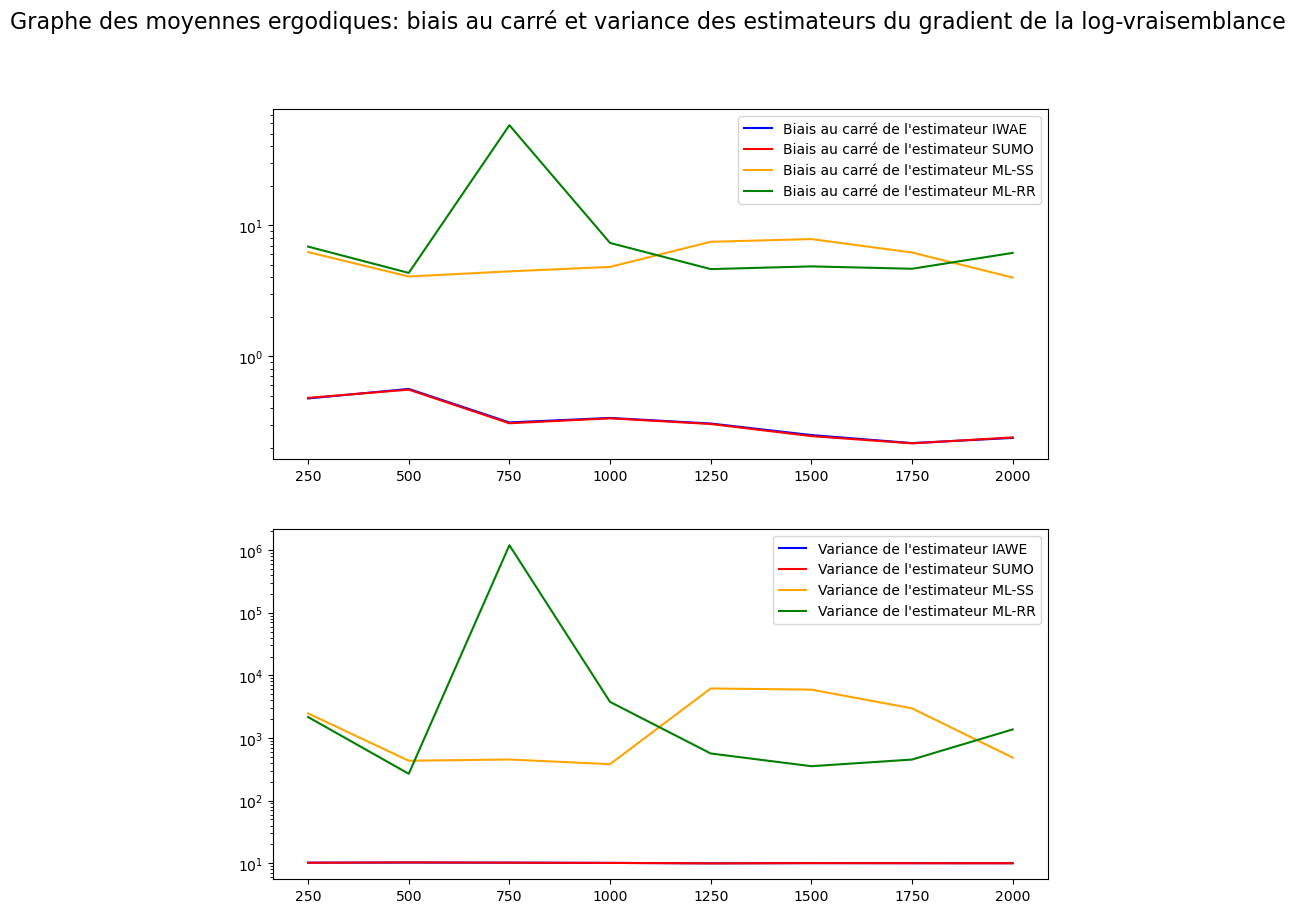

In [63]:
sorted_biais_IWAE_M = sorted(biais_gradient_IWAE_ergo.items())
sorted_biais_SUMO_M = sorted(biais_gradient_SUMO_ergo.items())
sorted_biais_SS_M = sorted(biais_gradient_SS_ergo.items())
sorted_biais_RR_M = sorted(biais_gradient_RR_ergo.items())

sorted_var_IWAE_M = sorted(var_gradient_IWAE_ergo.items())
sorted_var_SUMO_M = sorted(var_gradient_SUMO_ergo.items())
sorted_var_SS_M = sorted(var_gradient_SS_ergo.items())
sorted_var_RR_M = sorted(var_gradient_RR_ergo.items())

M, biais_IAWE = zip(*sorted_biais_IWAE_M)
M, biais_SUMO = zip(*sorted_biais_SUMO_M)
M, biais_SS = zip(*sorted_biais_SS_M)
M, biais_RR = zip(*sorted_biais_RR_M)

M, var_SUMO = zip(*sorted_var_SUMO_M)
M, var_SS = zip(*sorted_var_SS_M)
M, var_RR = zip(*sorted_var_RR_M)
M, var_IAWE = zip(*sorted_var_IWAE_M)


fig, axs = plt.subplots(2, 1, figsize=(10, 10))

axs[0].plot(M, biais_IAWE, 'b',
            label="Biais au carré de l'estimateur IWAE", color="blue")
axs[0].plot(M, biais_SUMO, 'b',
            label="Biais au carré de l'estimateur SUMO", color="red")
axs[0].plot(M, biais_SS, 'b',
            label="Biais au carré de l'estimateur ML-SS", color="orange")
axs[0].plot(M, biais_RR, 'b',
            label="Biais au carré de l'estimateur ML-RR", color="green")

axs[0].set_yscale("log")
axs[0].legend()

axs[1].plot(M, var_IAWE, 'b',
            label="Variance de l'estimateur IAWE", color="blue")
axs[1].plot(M, var_SUMO, 'b',
            label="Variance de l'estimateur SUMO", color="red")
axs[1].plot(M, var_SS, 'b',
            label="Variance de l'estimateur ML-SS", color="orange")
axs[1].plot(M, var_RR, 'b',
            label="Variance de l'estimateur ML-RR", color="green")

axs[1].set_yscale("log")
axs[1].legend()

fig.suptitle('Graphe des moyennes ergodiques: biais au carré et variance des estimateurs du gradient de la log-vraisemblance', fontsize=16)
plt.savefig('moyenne_ergo_gradient_logscale.png')
plt.show()


In [60]:
%store biais_IWAE_M
%store biais_SUMO_M
%store biais_SS_M
%store biais_RR_M
%store var_IWAE_M
%store var_SUMO_M
%store var_SS_M
%store var_RR_M

%store biais_IWAE_M_gradient
%store biais_SUMO_M_gradient
%store biais_SS_M_gradient
%store biais_RR_M_gradient
%store var_IWAE_M_gradient
%store var_SUMO_M_gradient
%store var_SS_M_gradient
%store var_RR_M_gradient

%store biais_IWAE_ergo
%store biais_SUMO_ergo
%store biais_SS_ergo
%store biais_RR_ergo
%store var_IWAE_ergo
%store var_SUMO_ergo
%store var_SS_ergo
%store var_RR_ergo

%store biais_gradient_IWAE_ergo
%store biais_gradient_SUMO_ergo
%store biais_gradient_SS_ergo
%store biais_gradient_RR_ergo
%store var_gradient_IWAE_ergo
%store var_gradient_SUMO_ergo
%store var_gradient_SS_ergo
%store var_gradient_RR_ergo


Stored 'biais_IWAE_M' (dict)
Stored 'biais_SUMO_M' (dict)
Stored 'biais_SS_M' (dict)
Stored 'biais_RR_M' (dict)
Stored 'var_IWAE_M' (dict)
Stored 'var_SUMO_M' (dict)
Stored 'var_SS_M' (dict)
Stored 'var_RR_M' (dict)
Stored 'biais_IWAE_M_gradient' (dict)
Stored 'biais_SUMO_M_gradient' (dict)
Stored 'biais_SS_M_gradient' (dict)
Stored 'biais_RR_M_gradient' (dict)
Stored 'var_IWAE_M_gradient' (dict)
Stored 'var_SUMO_M_gradient' (dict)
Stored 'var_SS_M_gradient' (dict)
Stored 'var_RR_M_gradient' (dict)
Stored 'biais_IWAE_ergo' (dict)
Stored 'biais_SUMO_ergo' (dict)
Stored 'biais_SS_ergo' (dict)
Stored 'biais_RR_ergo' (dict)
Stored 'var_IWAE_ergo' (dict)
Stored 'var_SUMO_ergo' (dict)
Stored 'var_SS_ergo' (dict)
Stored 'var_RR_ergo' (dict)
Stored 'biais_gradient_IWAE_ergo' (dict)
Stored 'biais_gradient_SUMO_ergo' (dict)
Stored 'biais_gradient_SS_ergo' (dict)
Stored 'biais_gradient_RR_ergo' (dict)
Stored 'var_gradient_IWAE_ergo' (dict)
Stored 'var_gradient_SUMO_ergo' (dict)
Stored 'var_gradie